# Singal To Noise All Models
 - Calculates the singal to nosie for all models in longrunmip for GMST
 - Fraction of models stable for windows for GMST
 
 PHD-9:
 * read_and_merge_netcdfs moved from longrunmip_loader to open_ds


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from importlib import reload
import os, sys
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import open_ds
import signal_to_noise as sn
import utils
from typing import List
from classes import ExperimentTypes
warnings.filterwarnings('ignore')
logger = utils.get_notebook_logger()

from functools import partial

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory('dask-worker-space')
dask.distributed.Client(local_directory=tempdir.name, memory_limit='32gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 119.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36279,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 119.21 GiB
Comm: tcp://127.0.0.1:46501,Total threads: 4
Dashboard: http://127.0.0.1:44577/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:38327,


In [3]:
VARIABLE_INFO = constants.VARIABLE_INFO
VARIABLE_INFO

notebook_number='03_01'

In [4]:
models_to_get =  constants.LONGRUNMIP_MODELS
utils.pprint_list(models_to_get, num_start_items=6)

lenght = 6
 0. ccsm3
 1. cnrmcm61
 2. hadcm3l
 3. ipslcm5a
 4. mpiesm11
 5. mpiesm12


In [5]:
reload(constants)
constants.EXPERIMENTS_TO_RUN

[{'variable': 'tas', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'tas', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'tos', 'mask': 'sea', 'hemisphere': 'global'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'global'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'northern_hemisphere'},
 {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'southern_hemisphere'}]

In [6]:
%%time
all_experiment_ds, all_control_ds = open_ds.get_all_experiment_ds(constants.EXPERIMENTS_TO_RUN,
                                                          constants.LONGRUNMIP_DIR, models_to_get)
all_experiment_ds


- {'variable': 'tas', 'mask': None, 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'tas', 'mask': 'land', 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'pr', 'mask': None, 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'pr', 'mask': 'land', 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'tos', 'mask': 'sea', 'hemisphere': 'global'}
- Removing first 10 steps
- Removing first 200 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'surf', 'mask': 'sea', 'hemisphere': 'global'}
- model='ipslcm5a' - found_fname=None - No file found
- model='ipslcm5a' - found_fname=None - No file found
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, mpiesm11, mpiesm12, 
- {'variabl

<xarray.Dataset>
Dimensions:                       (model: 6, time: 1200)
Coordinates:
  * model                         (model) <U8 'ccsm3' 'cnrmcm61' ... 'mpiesm12'
  * time                          (time) object 0001-12-31 00:00:00 ... 1200-...
Data variables:
    tas_global                    (model, time) float64 2.283 2.567 ... nan nan
    tas_land_global               (model, time) float64 3.075 3.226 ... nan nan
    pr_global                     (model, time) float64 28.58 48.38 ... nan nan
    pr_land_global                (model, time) float64 51.81 129.5 ... nan nan
    tos_sea_global                (model, time) float64 1.305 1.661 ... nan nan
    surf_sea_global               (model, time) float64 6.844 4.978 ... nan nan
    surf_sea_northern_hemisphere  (model, time) float64 9.452 6.499 ... nan nan
    surf_sea_southern_hemisphere  (model, time) float64 5.023 3.916 ... nan nan

In [8]:
max_effective_length = 850#sn.get_upper_lim(all_experiment_ds, MULTI_WINDOW_RUN_PARAMS['end_window']) # Broken
max_effective_length

850

In [23]:
constants.MULTI_WINDOW_RUN_PARAMS

{'start_window': 10, 'end_window': 152, 'step_window': 1}

In [9]:
%%time
stable_sn_ds, unstable_sn_ds = all_experiment_ds.sn_ds.sn_multiwindow(all_control_ds,
            **constants.MULTI_WINDOW_RUN_PARAMS, parallel=True)

- 
====tas_global


Experiment
--------

range(10, 152)
16, 13, 25, 10, 19, 22, 34, 37, 31, 28, 40, 49, 46, 43, 52, 55, 23, 38, 26, 41, 20, 50, 14, 35, 11, 47, 56, 32, 17, 39, 27, 21, 51, 53, 44, 18, 42, 57, 29, 24, 12, 58, 15, 36, 61, 48, 64, 54, 67, 70, 33, 30, 45, 65, 73, 76, 79, 82, 85, 62, 59, 88, 71, 91, 94, 97, 66, 68, 100, 72, 63, 103, 77, 83, 60, 69, 106, 74, 89, 78, 92, 80, 109, 112, 95, 98, 86, 93, 115, 104, 84, 107, 118, 75, 81, 96, 101, 121, 116, 99, 90, 105, 110, 119, 87, 113, 102, 124, 127, 130, 133, 136, 108, 139, 142, 114, 145, 122, 117, 148, 151, 111, 128, 125, 140, 120, 143, 131, 134, 146, 137, 126, 123, 149, 144, 129, 138, 141, 132, 135, 147, 150, 
Control
------

range(10, 152)
16, 13, 22, 10, 25, 19, 31, 43, 34, 28, 40, 37, 52, 55, 49, 46, 23, 14, 24, 47, 26, 17, 38, 41, 53, 35, 11, 20, 50, 27, 56, 44, 32, 29, 15, 18, 12, 36, 42, 58, 48, 39, 61, 51, 33, 64, 54, 67, 70, 30, 73, 76, 57, 62, 79, 45, 59, 65, 21, 77, 82, 85, 63, 68, 74, 80, 71, 83, 88, 91, 94, 69, 97, 

- 
====surf_sea_southern_hemisphere


Experiment
--------

range(10, 152)
31, 28, 13, 22, 19, 25, 10, 46, 37, 58, 49, 34, 43, 52, 40, 64, 16, 61, 67, 82, 76, 70, 55, 73, 85, 88, 97, 94, 79, 103, 91, 100, 106, 109, 115, 112, 121, 124, 145, 127, 148, 142, 118, 139, 151, 133, 136, 130, - !!!!!!!!!!!!!!!!!!!!!!


surf_sea_southern_hemisphere has error 
 <xarray.DataArray 'surf_sea_southern_hemisphere' (model: 6, time: 0)>
array([], shape=(6, 0), dtype=float64)
Coordinates:
  * model    (model) <U8 'ccsm3' 'cnrmcm61' 'hadcm3l' ... 'mpiesm11' 'mpiesm12'
  * time     (time) object  
 <xarray.DataArray 'surf_sea_southern_hemisphere' (model: 6, time: 0)>
array([], shape=(6, 0), dtype=float64)
Coordinates:
  * model    (model) <U8 'ccsm3' 'cnrmcm61' 'hadcm3l' ... 'mpiesm11' 'mpiesm12'
  * time     (time) object 


!!!!!!!!!!!!!!!!!!!!!!
CPU times: user 41.6 s, sys: 14.2 s, total: 55.8 s
Wall time: 5min 50s


In [10]:
stable_year_ds = sn.get_dataset_stable_year_multi_window(unstable_sn_ds)
stable_year_ds

<xarray.Dataset>
Dimensions:   (model: 6, window: 142, variable: 5)
Coordinates:
  * model     (model) <U8 'ccsm3' 'cnrmcm61' 'hadcm3l' ... 'mpiesm11' 'mpiesm12'
  * window    (window) int64 10 11 12 13 14 15 16 ... 146 147 148 149 150 151
  * variable  (variable) <U15 'tas_global' ... 'tos_sea_global'
Data variables:
    time      (variable, window, model) int64 20 46 16 31 28 ... 848 850 788 844

# Plotting

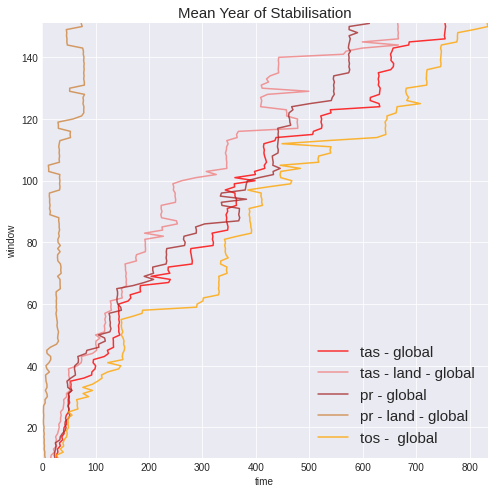

In [17]:
fig, ax = sn_plot.plot_year_of_stability(stable_year_ds.mean(dim='model'), 'variable', 
                                         title='Mean Year of Stabilisation')
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_mean_multivariate_year_of_stabilisation.png')
fig.savefig(save_name, dpi=200, bboox_inches='tight')

/home/563/ab2313/gdata/images/PhD/top_level/03_01_ccsm3_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_cnrmcm61_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_hadcm3l_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_ipslcm5a_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_mpiesm11_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_mpiesm12_multivariate_year_of_stabilisation.png


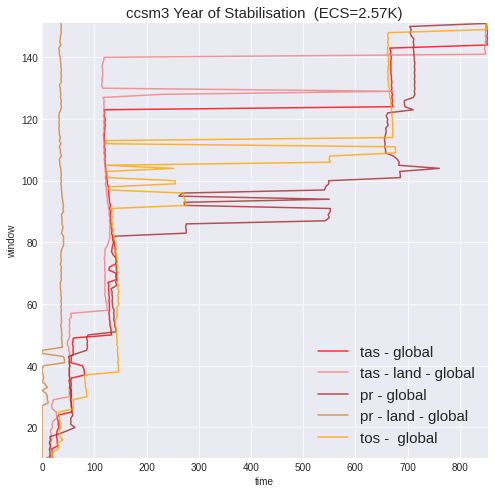

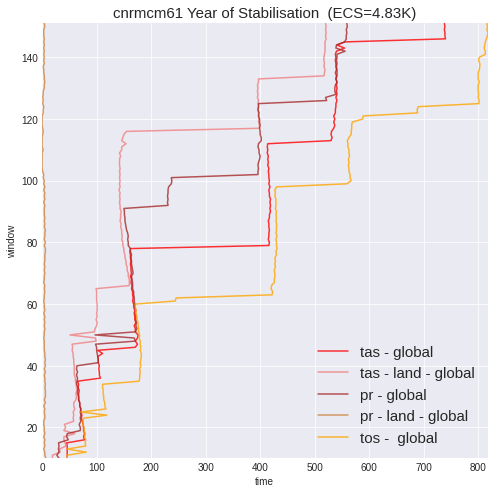

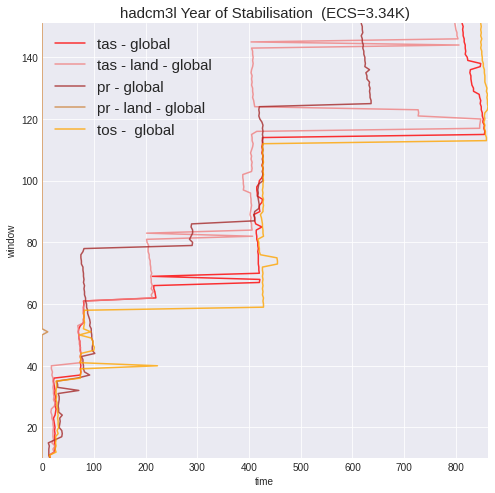

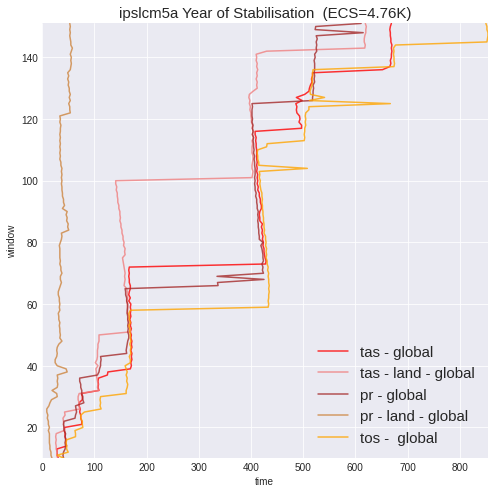

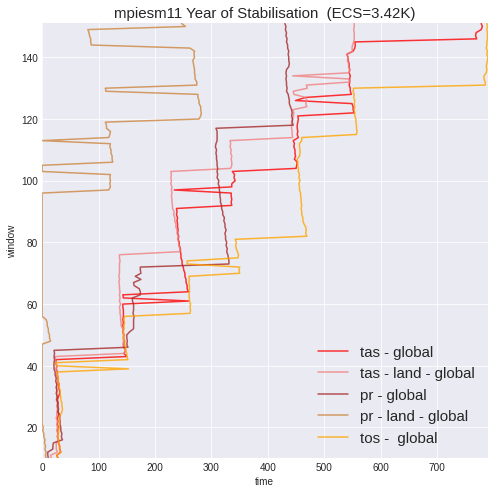

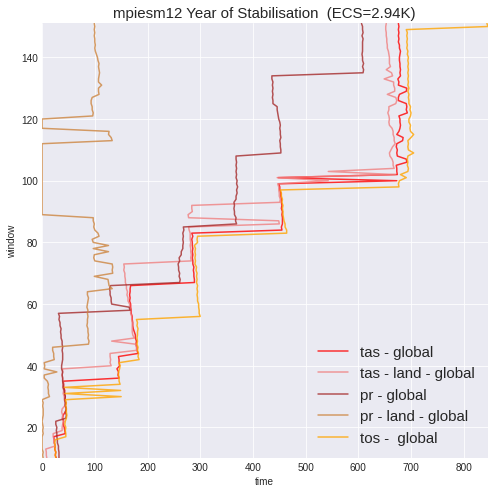

In [18]:
for model in stable_year_ds.model.values:
    fig, ax = sn_plot.plot_year_of_stability(stable_year_ds.sel(model=model), 'variable')
    save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                             f'{notebook_number}_{model}_multivariate_year_of_stabilisation.png')
    print(save_name)
    fig.savefig(save_name, dpi=200, bboox_inches='tight')

In [19]:
def scatter_ecs_vs_stabilisation_year(fig, ax, da: xr.DataArray, marker='o'):
    '''
    Scatter plot of the ECS vs the year of stability for a model
    
    '''
    
    MODEL_ECS = {model: value['ECS'] for model, value in constants.MODEL_PARAMS.items()
                if model in da.model.values}

    for model in list(MODEL_ECS):
        pt = [float(da.sel(model=model).time.values), MODEL_ECS[model]]
        ax.scatter(*pt, label=model, c = constants.MODEL_PARAMS[model]['color'], marker=marker)
        
    ax.set_title(f'{str(da.window.values)} Year Window Length', fontsize=12)
    ax.set_xlabel('Year of Stabilisation', size=12)

In [20]:
def ecs_vs_year_or_stabilisation_multipannel(ds: xr.Dataset, windows: List[int], 
                                            variable: str = None) -> (plt.figure, List[plt.axes]):

    fig = plt.figure(figsize=(15, 6))
    axes = []

    for i, window in enumerate(windows):
        ax = fig.add_subplot(1,3,i+1)
        axes.append(ax)

        da = ds.sel(window=window)
        scatter_ecs_vs_stabilisation_year(fig, ax, da)

    axes[0].set_ylabel('ECS (K)', size=12)
    leg = axes[1].legend(ncol=len(da.model.values), fontsize = 12, bbox_to_anchor=[1.8, 1.22], frameon=True) 
    leg.set_title('Model')
    leg.get_title().set_fontsize('12')
    
    variable_split = variable.split('_')
    longname = constants.VARIABLE_INFO[variable_split[0]]['longname'] if variable else ''
    hemishere = variable_split[-1].strip().capitalize()
    mask = f'({variable_split[1]} only)' if len(variable_split) > 2 else ''
         
    fig.suptitle(f'{hemishere} {longname} {mask}\nECS vs. Year Of Stabilisation ', 
                 y=1.15, fontsize=21);
    return fig, axes

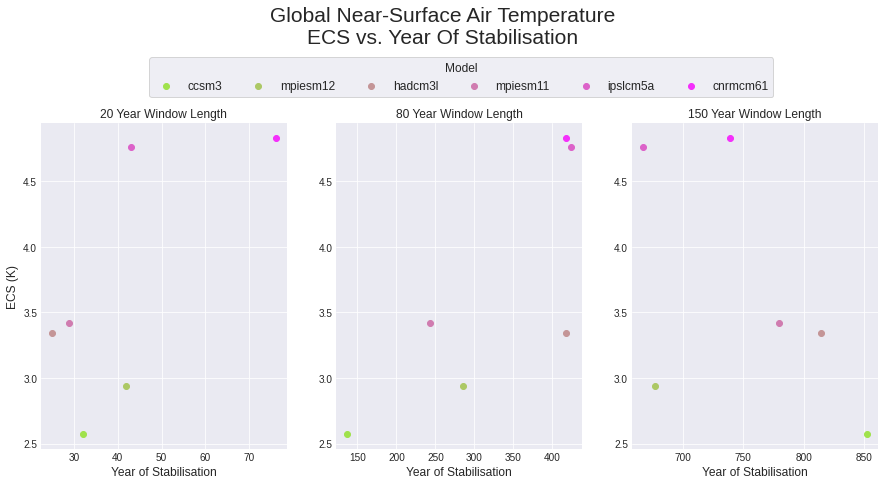

In [24]:
variable = 'tas_global'
fig, axes = ecs_vs_year_or_stabilisation_multipannel(
            stable_year_ds.sel(variable=variable), constants.WINDOWS_OF_INTEREST, variable) 

save_name = os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL,
    f'{notebook_number}_{variable}_ecs_vs_stable_year_scatter.png')
fig.savefig(save_name, dpi=200, bbox_inches='tight')

tas_global
tas_land_global
pr_global
pr_land_global
tos_sea_global


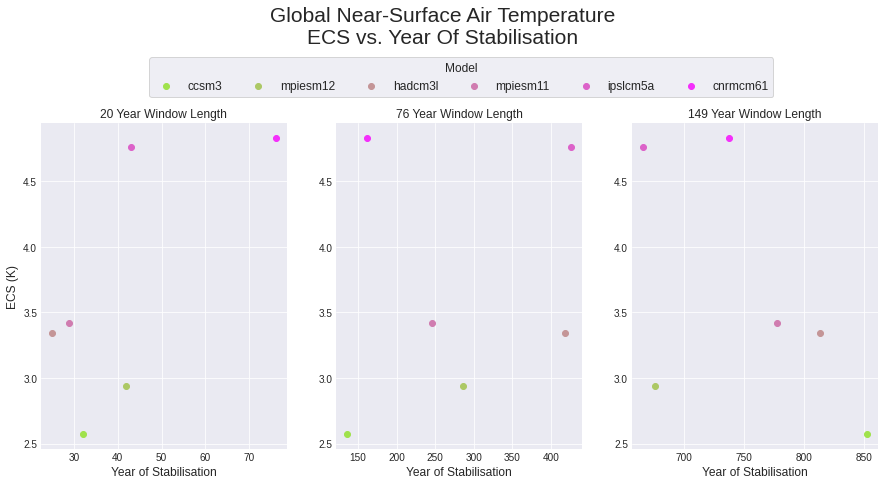

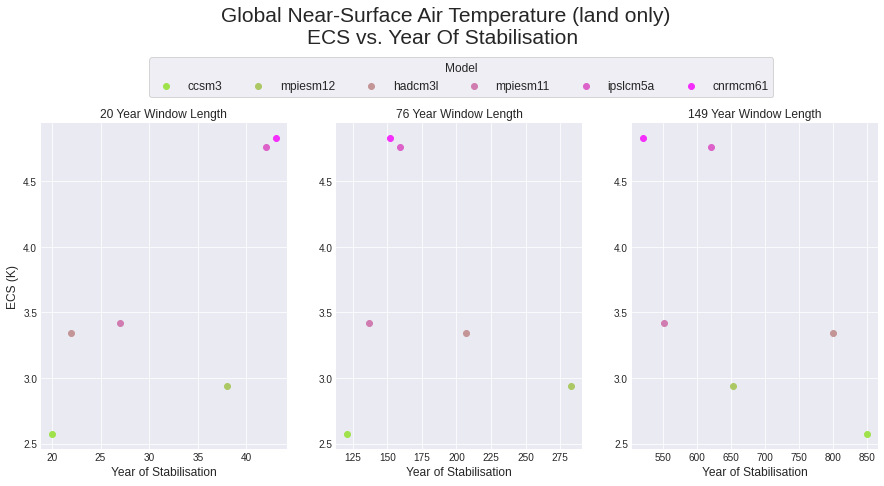

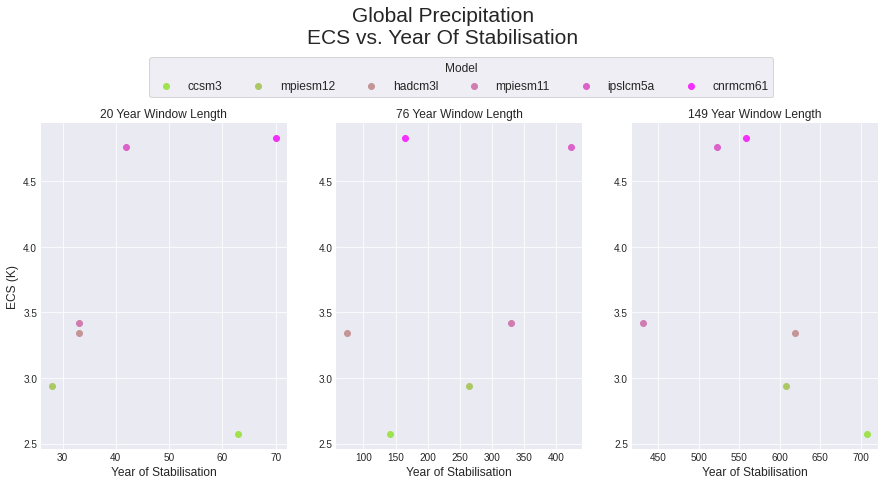

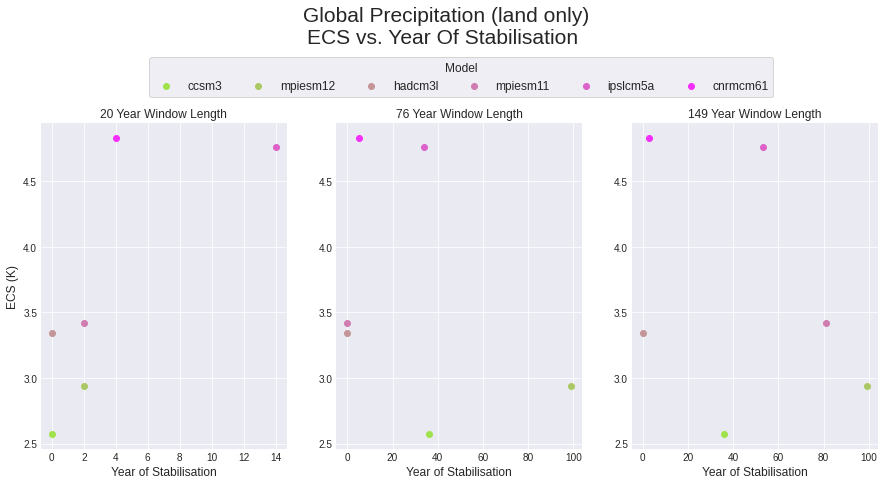

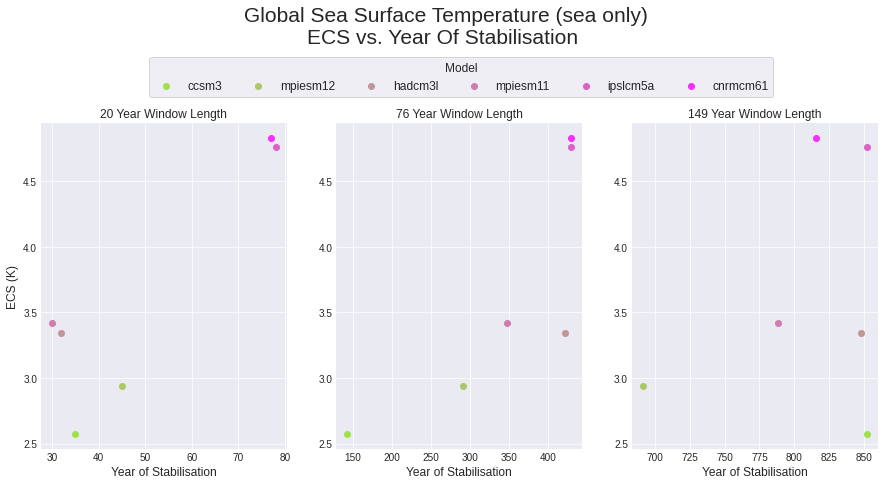

In [16]:
for variable in stable_year_ds.variable.values:
    print(variable)
    fig, axes = ecs_vs_year_or_stabilisation_multipannel(
                stable_year_ds.sel(variable=variable), constants.WINDOWS_OF_INTEREST, variable) 

    save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL,
        f'{notebook_number}_{variable}_ecs_vs_stable_year_scatter.png')
    fig.savefig(save_name, dpi=200, bbox_inches='tight')